# No event types continuously-observed process

Estimation of betas:

1. grid search GS
2. direct likelihood maximization DLM
3. two-stage regression TSR
4. expectation-maximization EM

In [1]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../src/')
sys.path.append('../scripts/')

from estimate_no_event_types import *
from simulate_gillespie import gillespie_sim_complete

from scipy.optimize import minimize
from scipy.optimize import least_squares

## Setup

In [2]:
N = 100 # TODO: increase
I0 = 10
time_max = 10.0
mu_true = 1.0

# true parameters for data generation 
# Case 1: "Balanced"
beta1_true, beta2_true = (2.4, 4.4)

# convert SCALED true betas to ORIGINAL per-interaction true betas
beta1_orig_true = beta1_true / N
beta2_orig_true = beta2_true / (N**2)

## Generate data

In [3]:
nsims = 1 # NOTE: single run
# TODO: try with 10, or even 100 runs

X_sims = []
for _ in range(nsims):
    X_t = gillespie_sim_complete(N, beta1_orig_true, beta2_orig_true, mu_true, I0, time_max)
    X_sims.append(X_t)

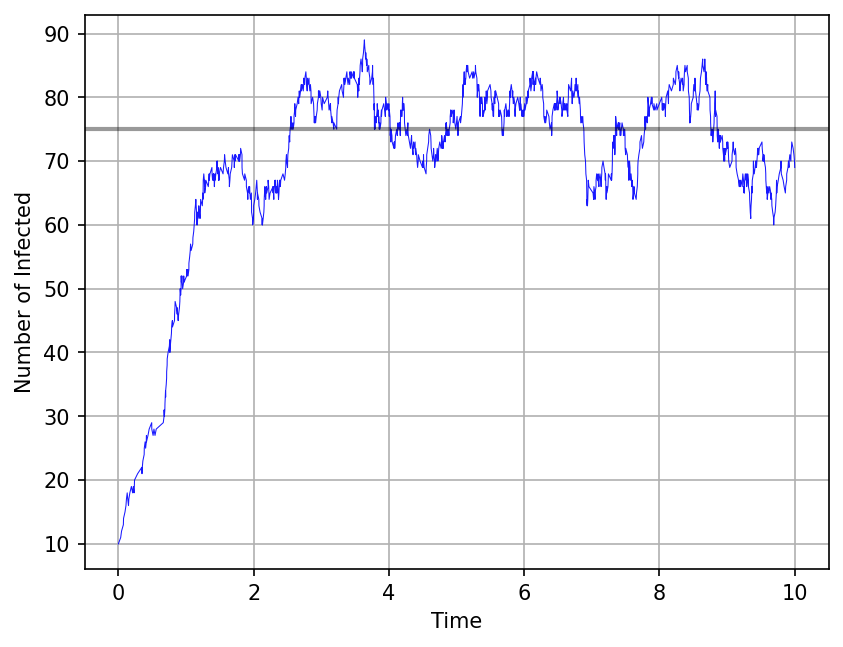

In [4]:
fig = plt.figure(dpi=150)
ax  = plt.subplot()
ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)
plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.show()

## Sufficient (aggregated) statistics

- $B_k$: Total number of observed births from state $k$.
- $D_k$: Total number of observed deaths from state $k$.
- $T_k$: Total time spent in state $k$.

In [5]:
stats = get_sufficient_stats(X_t, N)

In [6]:
print(f"Total time spent in states:")
visited_k = np.where(stats['T_k'] > 0)[0]
for k in visited_k[:5]:
    print(f"  k={k}: T_k = {stats['T_k'][k]:.4f}")

print(f"\nTotal births from states:")
birth_k = np.where(stats['B_k'] > 0)[0]
for k in birth_k[:5]:
    print(f"  k={k}: B_k = {int(stats['B_k'][k])}")

print(f"\nTotal deaths from states:")
death_k = np.where(stats['D_k'] > 0)[0]
for k in death_k[:5]:
    print(f"  k={k}: D_k = {int(stats['D_k'][k])}")

Total time spent in states:
  k=10: T_k = 0.0345
  k=11: T_k = 0.0126
  k=12: T_k = 0.0268
  k=13: T_k = 0.0028
  k=14: T_k = 0.0214

Total births from states:
  k=10: B_k = 1
  k=11: B_k = 1
  k=12: B_k = 1
  k=13: B_k = 1
  k=14: B_k = 1

Total deaths from states:
  k=17: D_k = 1
  k=18: D_k = 1
  k=19: D_k = 2
  k=22: D_k = 1
  k=26: D_k = 1


## Likelihood 

$$
\ell(\beta_1, \beta_2) = \sum_{k = 0}^{N} \left[ B_k \ln(\lambda_k(\beta_1, \beta_2)) + D_k \ln(\mu_k(\mu)) - (\lambda_k(\beta_1, \beta_2) + \mu_k(\mu)) T_k \right]
$$

Create grid and plot the likelihood surface:

## Plotting

In [7]:
b1_range = (0, 6.0, 100)
b2_range = (0, 12.0, 100)
surface_data = compute_likelihood_surface(b1_range, b2_range, stats, N, mu_true)

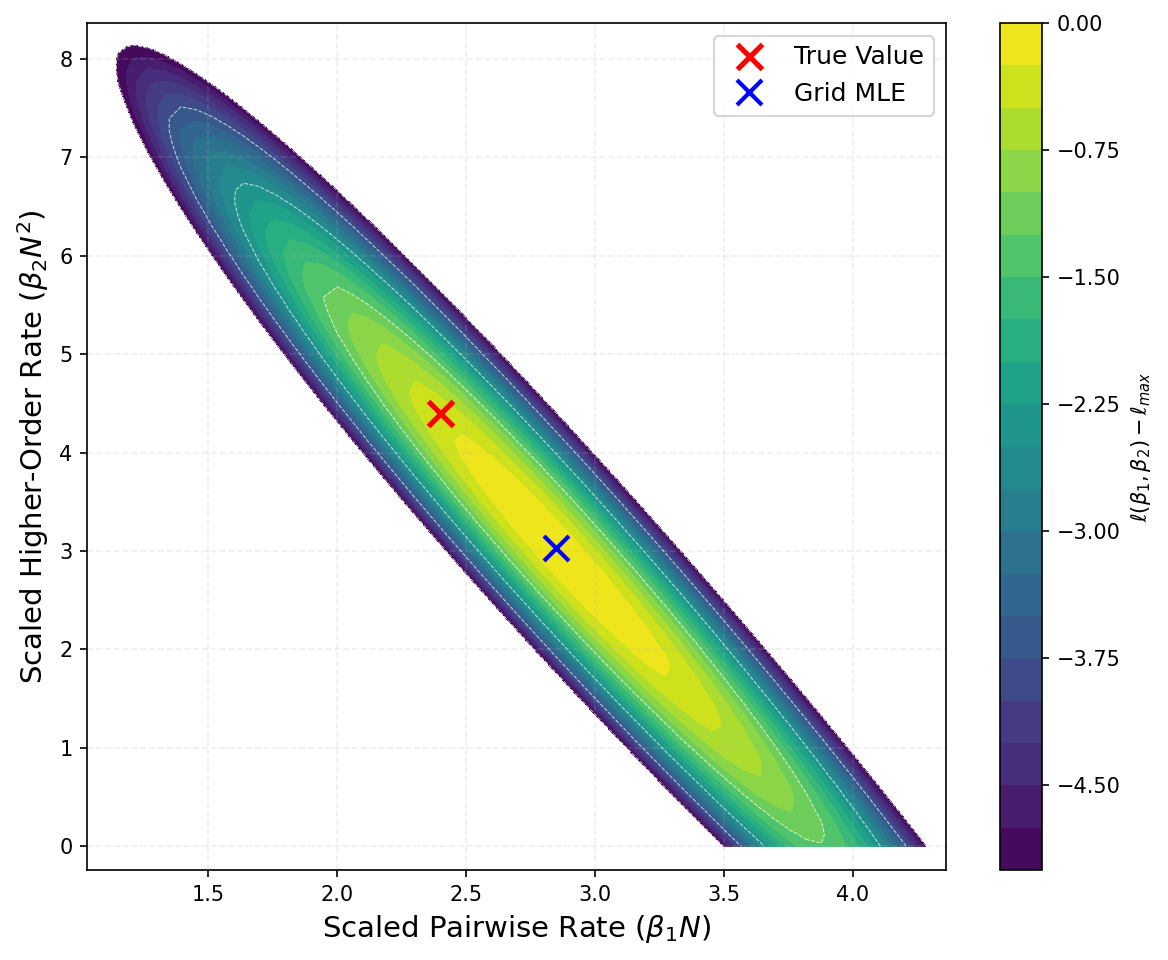

In [8]:
plot_zoomed_likelihood(surface_data, (beta1_true, beta2_true), threshold=-5.0)

In [9]:
beta1_true, beta2_true

(2.4, 4.4)

In [10]:
grid_search(stats, N, mu_true)

(np.float64(2.909090909090909), np.float64(2.878787878787879))

In [11]:
estimate_dlm(stats, N, [0.01 / N, 0.01 / (N**2)])

(np.float64(2.86275318741573), np.float64(2.9902611741747562))

In [12]:
estimate_dlm(stats, N, [1 / N, 1 / (N**2)])

(np.float64(2.8630735251431636), np.float64(2.9895217148833684))

In [13]:
estimate_dlm(stats, N, [1, 1])

(np.float64(2.8630077390010418), np.float64(2.98952085977228))

In [14]:
estimate_tsr(stats, N, [1, 1])

(np.float64(2.729914334913329), np.float64(3.3204979386775557))

In [15]:
estimate_tsr(stats, N, [1 / N, 1 / (N**2)])

(np.float64(2.7299144109713027), np.float64(3.3204977115846357))

In [16]:
estimate_tsr(stats, N, [0.01 / N, 0.01 / (N**2)])

(np.float64(2.7299142051554), np.float64(3.3204983257478613))

## DLM

## TSR

1. stage: estimate birth rates $\lambda_k$ for each state $k$ visited

2. stage: fit $\beta_1 f_1(k) + \beta_2 f_2(k)$ to $(k, \lambda_k)$ points

NOTE: Needs to be weighted least-squares:

- the variance around each point is not the same

- the number of births $B_k$ from state $k$ is a Poisson r.v. with mean $\lambda_k T_k$

- the variance is also $\lambda_k T_k$

Approximate weights as $T_k$ since we do not know the true $\lambda_k$

In [17]:
# initial guess could be something small
x0 = [0.01 / N, 0.01 / (N**2)]